# Experiment: Feature Manifold Replication in Sentences

## 1. The Problem
Current Interpretability methods often rely on **Attention Heatmaps** to determine if a model is "moving information" from one part of a sentence to another. However, attention can be misleading (e.g., the "Attention Sink" phenomenon).

## 2. The Hypothesis
If a model successfully copies information (e.g., a Date) from a source token to a destination token, the **Feature Manifold** (the geometric shape of that data) should appear at the destination.

## 3. The Experiment
We will use **Supervised Multi-Dimensional Scaling (SMDS)** to detect the presence of a "Date Manifold" (a circular structure) at every single token in a sentence.

**The Pipeline:**
1.  **Generate Data:** Create hundreds of sentences with a fixed structure but varying dates (e.g., *"Alice was born on [Date]..."*).
2.  **Record Activations:** Pass these sentences through an LLM and save the hidden states for every token.
3.  **Apply SMDS:** Test every token position: *Does this token's activation space look like a circle?*

In [1]:
# Install necessary libraries if not present
# %pip install torch transformers numpy pandas tqdm matplotlib

import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import random
from datetime import datetime, timedelta

# Visualization settings
import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


We need a dataset where the **structure is identical** (so token $i$ always corresponds to the same word), but the **content (the date)** changes.

We will generate samples where:
1.  **$X$ (The Input):** A sentence mentioning a birthday.
2.  **$y$ (The Label):** The day of the year (0-365), normalized to $[0, 1]$.

In [2]:
def get_ordinal_date(n):
    """
    Converts int 13 -> string '13th', 1 -> '1st', etc.
    Necessary to make the sentence natural for the LLM.
    """
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

def get_day_of_year(month, day):
    """Converts a month/day to a normalized float [0, 1]."""
    date = datetime(2023, month, day)
    day_of_year = date.timetuple().tm_yday - 1
    return day_of_year / 365.0

def generate_dataset(n_samples=500):
    """
    Generates sentences using the specific task description template.
    Template: "Anna was born on the 13th of December. Anna plays volleyball..."
    """

    # Template with placeholders
    # We use {Name} multiple times as per the paragraph structure
    template = (
        "{Name} was born on the {Day_Ordinal} of {Month}. "
        "{Name} plays volleyball. "
        "{Name}'s favourite color is green. "
        "{Name} lives in Berlin. "
        "{Name} had a party on her birthday."
    )

    months = [
        ("January", 31), ("February", 28), ("March", 31), ("April", 30),
        ("May", 31), ("June", 30), ("July", 31), ("August", 31),
        ("September", 30), ("October", 31), ("November", 30), ("December", 31)
    ]

    # List of names to vary
    # Using names of same token length helps alignment.
    # 'Anna', 'Lily', 'Mark', 'Paul' are often single tokens.
    names = ["Anna", "Mary", "John", "Paul", "Mark", "Lisa"]

    texts = []
    labels = []

    for _ in range(n_samples):
        # 1. Sample Name and Date
        name = random.choice(names)
        m_idx = random.randint(0, 11)
        m_name, max_days = months[m_idx]
        day = random.randint(1, max_days)

        # 2. Calculate Label (y) -> Normalized Day of Year
        y_val = get_day_of_year(m_idx + 1, day)

        # 3. Format Date string (e.g., "13th")
        day_ord = get_ordinal_date(day)

        # 4. Fill Template
        text = template.format(
            Name=name,
            Day_Ordinal=day_ord,
            Month=m_name
        )

        texts.append(text)
        labels.append(y_val)

    return texts, np.array(labels)

# Generate the data
texts, y_labels = generate_dataset(n_samples=1000)

# Preview
print(f"Total Samples: {len(texts)}")
print(f"Sample 0 Label: {y_labels[0]:.4f}")
print(f"Sample 0 Text:\n{texts[0]}")

Total Samples: 1000
Sample 0 Label: 0.1808
Sample 0 Text:
Lisa was born on the 8th of March. Lisa plays volleyball. Lisa's favourite color is green. Lisa lives in Berlin. Lisa had a party on her birthday.


We will use `gpt2` for this demo because it is small and fast. If you have the computational resources, switch the `model_name` to `meta-llama/Llama-3.2-3B-Instruct` or similar.

**Crucial Step:** We must ensure all sentences tokenize to the **exact same length**. If "May" is 1 token and "September" is 1 token, we are fine. If lengths differ, we cannot stack the activations into a simple tensor without padding logic.

In [3]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# 1. Load the environment variables
load_dotenv()

# 2. Get the token
hf_token = os.getenv("HF_TOKEN")

if not hf_token:
    raise ValueError("HF_TOKEN not found in .env file! Please create one.")

# 3. Authenticate
# This saves the credential so transformers can find it automatically
login(token=hf_token)

print("Hugging Face Login Successful.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face Login Successful.


In [4]:
""""# CELL 6: Load SOTA Model (Llama-3.1-8B)

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Config for 4-bit loading (Fits comfortably in 24GB VRAM)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model_id = "meta-llama/Llama-3.1-8B-Instruct"
# Alternative if you don't have Llama access: "Qwen/Qwen2.5-7B-Instruct"

print(f"Loading {model_id} on RTX 4090...")

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager" # Keep eager for Attention Analysis later!
)

tokenizer.pad_token = tokenizer.eos_token

print("Model Loaded Successfully.")

# CELL: Re-Tokenize and Align

# Re-tokenize with the NEW tokenizer
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

print(f"New Tensor Shape: {inputs['input_ids'].shape}")

print(f"\n{'Index':<6} | {'Sample 0':<15} | {'Sample 1':<15} | {'Sample 2':<15}")
print("-" * 60)

for t_idx in range(inputs['input_ids'].shape[1]):
    t0 = tokenizer.decode(inputs['input_ids'][0][t_idx])
    t1 = tokenizer.decode(inputs['input_ids'][1][t_idx])
    t2 = tokenizer.decode(inputs['input_ids'][2][t_idx])

    # Highlight mismatches
    marker = "" if (t0 == t1 == t2) else " <--- Varies"
    print(f"{t_idx:<6} | {repr(t0):<15} | {repr(t1):<15} | {repr(t2):<15} {marker}")

print("\n>>> UPDATE YOUR 'tokens_of_interest' DICTIONARY WITH THESE NEW INDICES!")

# Let's inspect the tokens of the first sample to map our analysis later
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("\n--- Token Mapping ---")
for i, tok in enumerate(sample_tokens):
    print(f"Pos {i}: {tok}")
print("---------------------")"""

'"# CELL 6: Load SOTA Model (Llama-3.1-8B)\n\nimport torch\nfrom transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig\n\n# Config for 4-bit loading (Fits comfortably in 24GB VRAM)\nbnb_config = BitsAndBytesConfig(\n    load_in_4bit=True,\n    bnb_4bit_compute_dtype=torch.float16,\n    bnb_4bit_use_double_quant=True,\n)\n\nmodel_id = "meta-llama/Llama-3.1-8B-Instruct"\n# Alternative if you don\'t have Llama access: "Qwen/Qwen2.5-7B-Instruct"\n\nprint(f"Loading {model_id} on RTX 4090...")\n\ntokenizer = AutoTokenizer.from_pretrained(model_id)\nmodel = AutoModelForCausalLM.from_pretrained(\n    model_id,\n    quantization_config=bnb_config,\n    device_map="auto",\n    attn_implementation="eager" # Keep eager for Attention Analysis later!\n)\n\ntokenizer.pad_token = tokenizer.eos_token\n\nprint("Model Loaded Successfully.")\n\n# CELL: Re-Tokenize and Align\n\n# Re-tokenize with the NEW tokenizer\ninputs = tokenizer(texts, return_tensors="pt", padding=True, truncatio

In [5]:
# CELL 6: Load Qwen2.5-7B-Instruct (The "Llama Killer")
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

os.environ["HF_HOME"] = "./hf_cache"

print(f"Hugging Face models will be stored in: {os.environ['HF_HOME']}")

# Config for 4-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Qwen is an excellent alternative.
# It has a massive context window and very sharp reasoning.
model_id = "Qwen/Qwen2.5-7B-Instruct"

print(f"Loading {model_id} on RTX 4090...")

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager"
)

tokenizer.pad_token = tokenizer.eos_token

print("Model Loaded Successfully.")

Hugging Face models will be stored in: ./hf_cache
Loading Qwen/Qwen2.5-7B-Instruct on RTX 4090...


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Model Loaded Successfully.


In [7]:
# CELL: Re-Tokenize and Align

# Re-tokenize with the NEW tokenizer
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

print(f"New Tensor Shape: {inputs['input_ids'].shape}")

print(f"\n{'Index':<6} | {'Sample 0':<15} | {'Sample 1':<15} | {'Sample 2':<15}")
print("-" * 60)

for t_idx in range(inputs['input_ids'].shape[1]):
    t0 = tokenizer.decode(inputs['input_ids'][0][t_idx])
    t1 = tokenizer.decode(inputs['input_ids'][1][t_idx])
    t2 = tokenizer.decode(inputs['input_ids'][2][t_idx])

    # Highlight mismatches
    marker = "" if (t0 == t1 == t2) else " <--- Varies"
    print(f"{t_idx:<6} | {repr(t0):<15} | {repr(t1):<15} | {repr(t2):<15} {marker}")

print("\n>>> UPDATE YOUR 'tokens_of_interest' DICTIONARY WITH THESE NEW INDICES!")

# Let's inspect the tokens of the first sample to map our analysis later
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("\n--- Token Mapping ---")
for i, tok in enumerate(sample_tokens):
    print(f"Pos {i}: {tok}")
print("---------------------")

New Tensor Shape: torch.Size([1000, 36])

Index  | Sample 0        | Sample 1        | Sample 2       
------------------------------------------------------------
0      | 'Lisa'          | 'Lisa'          | 'Lisa'          
1      | ' was'          | ' was'          | ' was'          
2      | ' born'         | ' born'         | ' born'         
3      | ' on'           | ' on'           | ' on'           
4      | ' the'          | ' the'          | ' the'          
5      | ' '             | ' '             | ' '             
6      | '8'             | '2'             | '2'              <--- Varies
7      | 'th'            | '1'             | 'nd'             <--- Varies
8      | ' of'           | 'st'            | ' of'            <--- Varies
9      | ' March'        | ' of'           | ' June'          <--- Varies
10     | '.'             | ' April'        | '.'              <--- Varies
11     | ' Lisa'         | '.'             | ' Lisa'          <--- Varies
12     | ' plays'   

Now we perform the extraction. We will define a hook (or simple loop) to grab the hidden states.
We are creating a Tensor **X** of shape `(N_Samples, N_Layers, N_Tokens, Hidden_Dim)`.

*Note: For 1000 samples on GPT2, this fits in RAM. For Llama-70B, you would need to process in batches and save to disk.*

In [9]:
def record_activations(model, inputs, batch_size=32):
    """
    Passes inputs through model and collects hidden states for all layers.
    Returns: numpy array (N_samples, N_layers, N_tokens, Hidden_dim)
    """
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    n_samples = input_ids.shape[0]
    n_layers = model.config.num_hidden_layers + 1 # +1 for embedding layer usually included in output
    seq_len = input_ids.shape[1]
    hidden_dim = model.config.hidden_size

    # Pre-allocate memory (Caution: This can get large!)
    # shape: (Samples, Layers, Tokens, Dim)
    all_acts = np.zeros((n_samples, n_layers, seq_len, hidden_dim), dtype=np.float32)

    print(f"Recording activations. Output shape: {all_acts.shape}")

    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, n_samples, batch_size)):
            batch_ids = input_ids[i:i+batch_size].to(device)
            batch_mask = attention_mask[i:i+batch_size].to(device)

            # Forward pass with output_hidden_states=True
            outputs = model(batch_ids, attention_mask=batch_mask, output_hidden_states=True)

            # outputs.hidden_states is a tuple of (Layer_0, Layer_1, ... Layer_N)
            # Each layer tensor is (Batch, Seq, Dim)

            # Stack layers for this batch -> (Layers, Batch, Seq, Dim)
            batch_acts = torch.stack(outputs.hidden_states).cpu().numpy()

            # Transpose to (Batch, Layers, Seq, Dim) to match our storage
            batch_acts = batch_acts.transpose(1, 0, 2, 3)

            # Store
            current_batch_size = batch_ids.shape[0]
            all_acts[i:i+current_batch_size] = batch_acts

    return all_acts

# Run recording
X_activations = record_activations(model, inputs, batch_size=32)

print("\nExtraction Complete.")
print(f"X shape: {X_activations.shape}")
print(f"y shape: {y_labels.shape}")

Recording activations. Output shape: (1000, 29, 36, 3584)


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Extraction Complete.
X shape: (1000, 29, 36, 3584)
y shape: (1000,)


We now have our Data ($X$) and our Manifold Labels ($y$).
In the next phase, we will:
1.  Load the **SMDS** class and **CircularShape** class.
2.  Iterate through every Token Position ($t=0$ to $t=End$).
3.  Run SMDS on `X[:, layer, t, :]` vs `y`.
4.  Plot the resulting Stress curve.

In [10]:
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape

# Initialize storage for the Stress Map
# Shape: (Layers, Tokens)
# We will store the stress value (lower is better)
n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
stress_map = np.zeros((n_layers, n_tokens))

print(f"Running SMDS on {n_layers} layers and {n_tokens} tokens...")

# We use the CircularShape because dates cycle (Dec 31 -> Jan 1)
shape_hypothesis = CircularShape()

# Iterate over layers and tokens
for layer in tqdm(range(n_layers), desc="Layers"):
    for token in range(n_tokens):

        # 1. Isolate the data for this specific location
        # Shape: (1000, 768)
        X_location = X_activations[:, layer, token, :]

        # 2. Initialize SMDS
        # n_components=2 because a circle lives naturally in 2D
        reducer = SupervisedMDS(
            manifold=shape_hypothesis,
            n_components=2
        )

        # 3. Fit and Calculate Stress
        # .fit() finds the best projection W
        # .score() returns the Stress (Mismatch between X and y)
        try:
            reducer.fit(X_location, y_labels)
            stress = reducer.score(X_location, y_labels)
        except Exception as e:
            # Fallback for numerical instability (rare)
            stress = np.nan

        stress_map[layer, token] = stress

print("Analysis Complete.")

Running SMDS on 29 layers and 36 tokens...


Layers: 100%|██████████| 29/29 [15:17<00:00, 31.65s/it]

Analysis Complete.


We will visualize the entire sentence. We look for **dark vertical bands** (Low Stress) indicating columns where the Date concept is present across many layers.

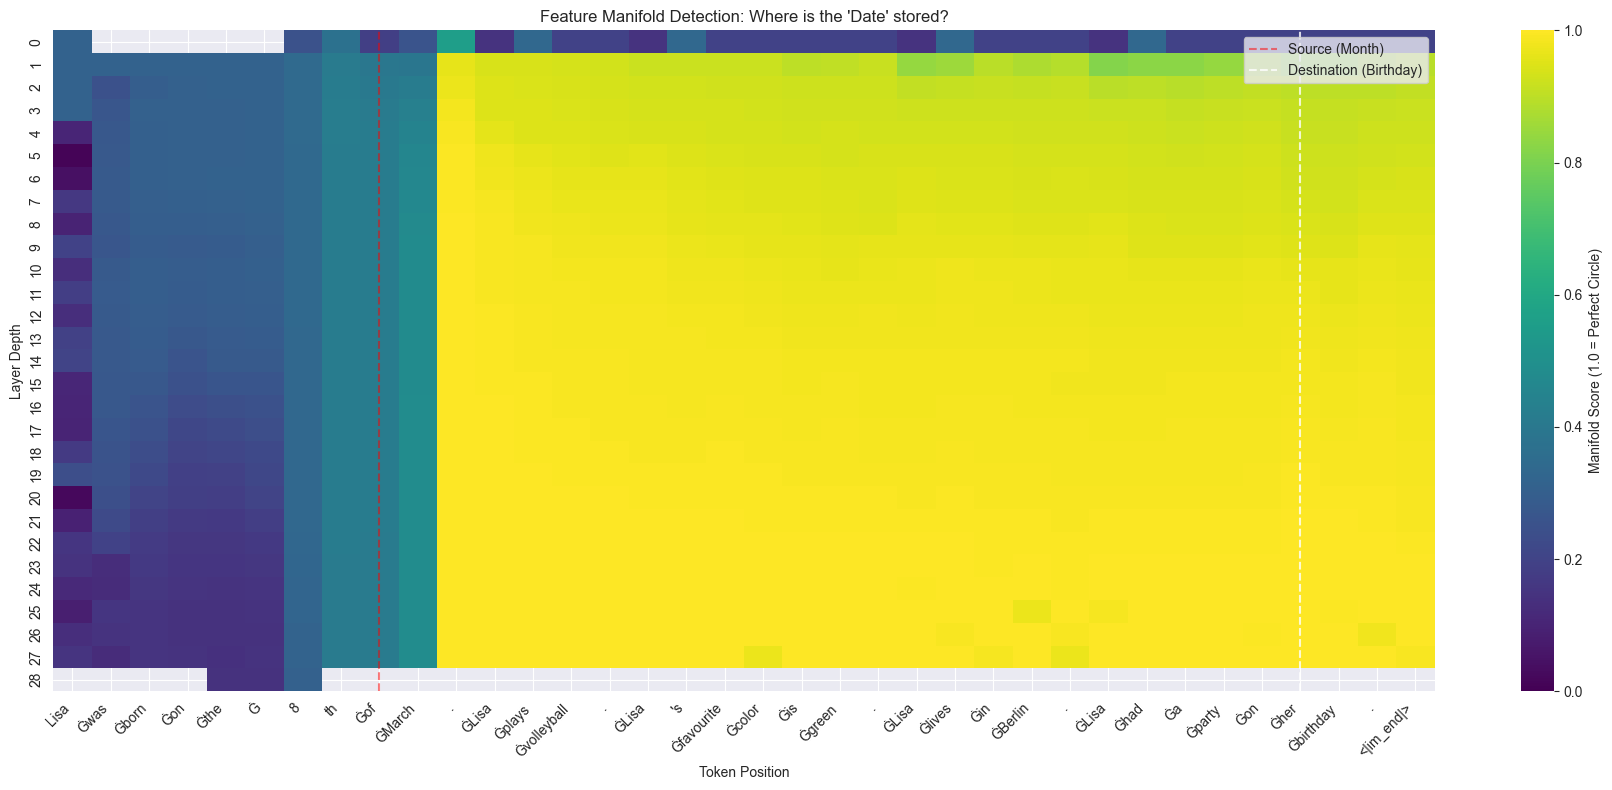

In [13]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(18, 8))

# HEATMAP CONFIGURATION
# viridis: Yellow = High (1.0), Purple = Low (0.0)
# We want Yellow to mean "Manifold Found!"
sns.heatmap(
    stress_map,
    cmap="viridis",
    vmin=0, vmax=1,  # Anchor scale between 0 and 1
    cbar_kws={'label': 'Manifold Score (1.0 = Perfect Circle)'}
)

# Labeling X-axis
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(
    ticks=np.arange(len(sample_tokens)) + 0.5,
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.xlabel("Token Position")
plt.ylabel("Layer Depth")
plt.title("Feature Manifold Detection: Where is the 'Date' stored?")

# Highlight Hypothesis Areas
# Pos 8 (Month) -> Source
# Pos 32 (Birthday) -> Destination
plt.axvline(x=8.5, color='red', linestyle='--', alpha=0.5, label='Source (Month)')
plt.axvline(x=32.5, color='white', linestyle='--', alpha=0.8, label='Destination (Birthday)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Heatmaps can be noisy. Let's pick a middle layer (e.g., Layer 6) and plot the stress as a line graph. This is where we verify your hypothesis about the "birthday" token.

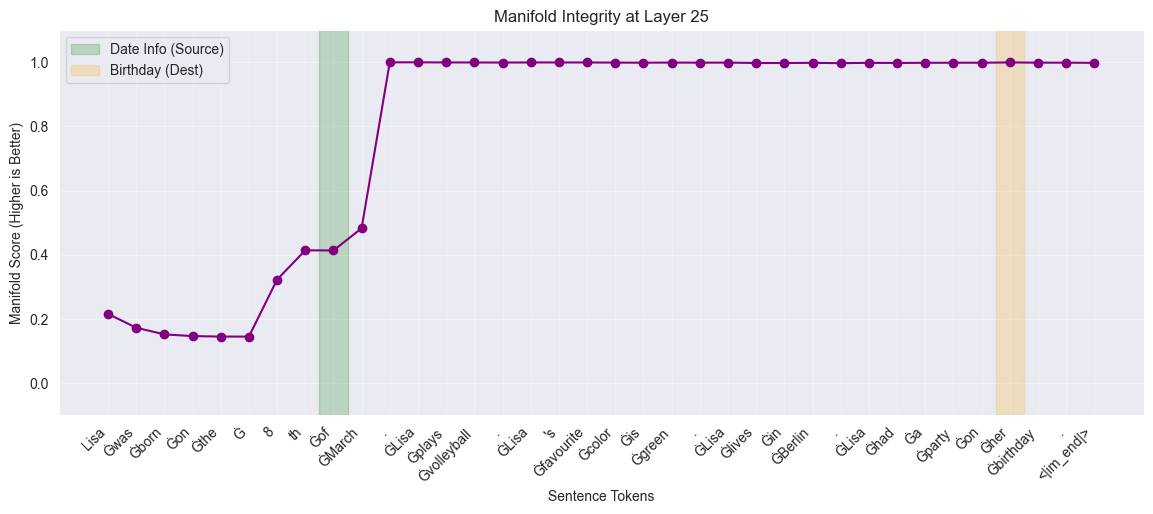

In [32]:
target_layer = 25  # Adjust this based on what the heatmap shows!

plt.figure(figsize=(14, 5))
plt.plot(stress_map[target_layer, :], marker='o', linestyle='-', color='purple')

# Add Labels
plt.xticks(
    ticks=np.arange(len(sample_tokens)),
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.ylabel("Manifold Score (Higher is Better)")
plt.ylim(-0.1, 1.1) # Fix y-axis to see the 0-1 range clearly
plt.xlabel("Sentence Tokens")
plt.title(f"Manifold Integrity at Layer {target_layer}")
plt.grid(True, alpha=0.3)

# Highlight zones
plt.axvspan(7.5, 8.5, color='green', alpha=0.2, label="Date Info (Source)")
plt.axvspan(31.5, 32.5, color='orange', alpha=0.2, label="Birthday (Dest)")
plt.legend()

plt.show()

>>> STEP 1: Auto-Detecting Token Indices...
Detected Indices: {'Source (Month)': 9, 'Destination (Birthday)': 33, 'Distractor': 13}

>>> STEP 2: Running Robust SMDS Analysis...


Analyzing Layers:  97%|█████████▋| 28/29 [15:45<00:32, 32.54s/it]Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
Q:\_0_Projects\00_DASP\supervised-multidimensional-s

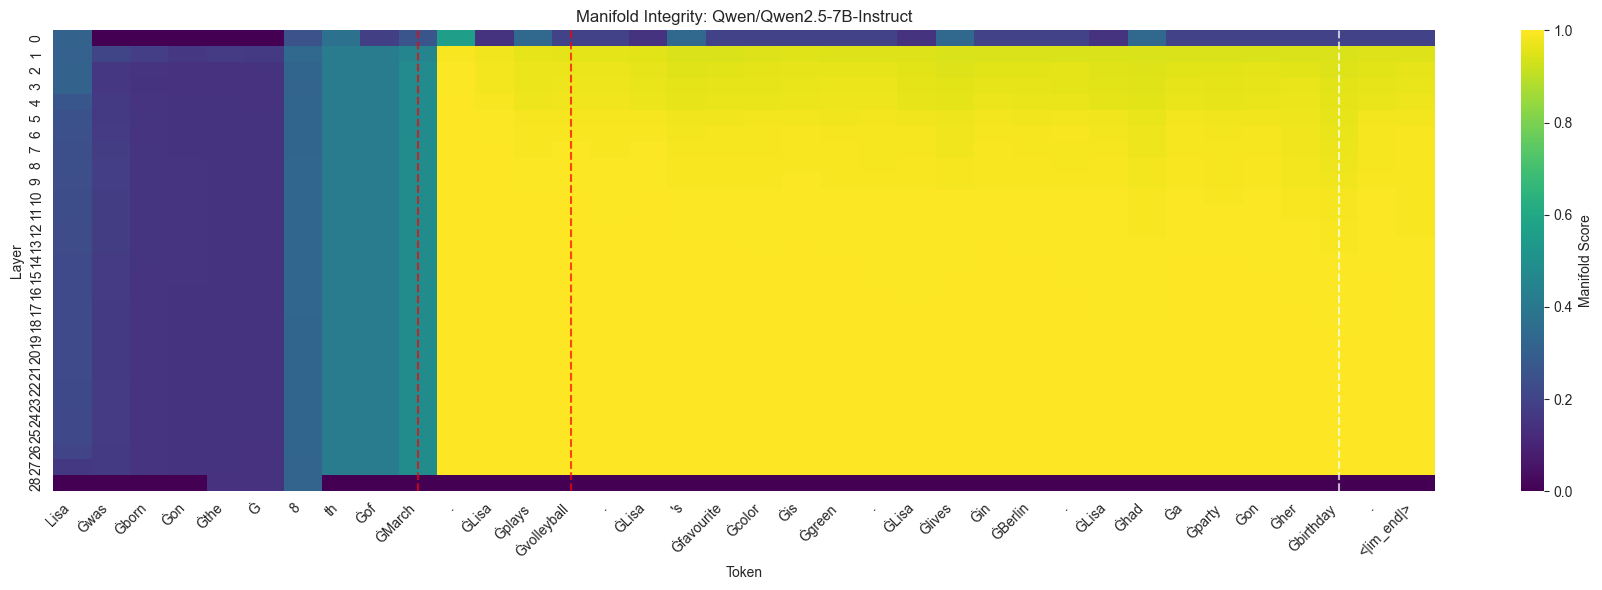


>>> STEP 3: Inspecting Representative Layers...


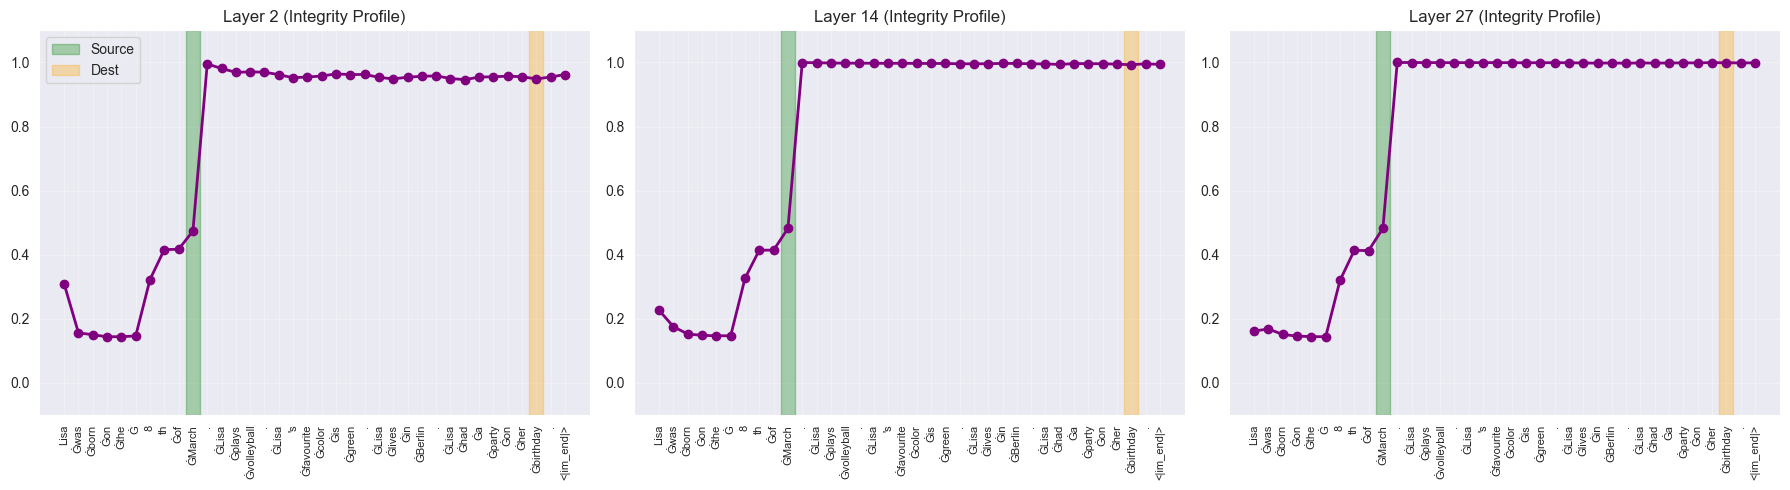


>>> STEP 4: Final Verification...
Control Test on 'ĠMarch' (Layer 27):
  Signal Score: 0.4826
  Noise Score : 0.4644
  Gap         : 0.0182

--- EXPERIMENT VERDICT ---
Max Score at Birthday   : 0.9989
Max Score at Distractor : 0.9995
❌ FAILURE: Method is overfitting noise. Increase N_samples or reduce dimensions.


In [31]:
# --- MEGA-EVALUATION CELL ---
# Runs Analysis, Visualization, Multi-Layer Inspection, and Verification.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# --- 1. AUTOMATIC TOKEN MAPPING ---
print(">>> STEP 1: Auto-Detecting Token Indices...")

# Get Sample 0 details
sample_ids = inputs['input_ids'][0]
tokens_str = [tokenizer.decode([tid]).strip() for tid in sample_ids]
# For visualization labels (keep special chars)
viz_labels = tokenizer.convert_ids_to_tokens(sample_ids)

def find_token_index(keywords):
    """Finds the first index containing any of the keywords."""
    if isinstance(keywords, str): keywords = [keywords]
    for key in keywords:
        for i, tok in enumerate(tokens_str):
            # Check containment (case insensitive)
            if key.lower() in tok.lower() and len(tok) >= 1:
                return i
    return -1

# Hardcoded list of months to find the specific one in this sample
months_list = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

idx_month = find_token_index(months_list)
idx_bday = find_token_index(["birthday"])
idx_distractor = find_token_index(["volleyball", "lives", "color"]) # Try a few known words
idx_day = idx_month - 3 if idx_month > 3 else 6 # Heuristic for day number

indices = {
    "Source (Month)": idx_month,
    "Destination (Birthday)": idx_bday,
    "Distractor": idx_distractor
}

print(f"Detected Indices: {indices}")
if idx_month == -1 or idx_bday == -1:
    print("WARNING: Could not auto-detect indices. Please check manually.")

# --- 2. ROBUST SMDS ANALYSIS ---
print("\n>>> STEP 2: Running Robust SMDS Analysis...")

n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
stress_map = np.zeros((n_layers, n_tokens))
shape_hypothesis = CircularShape()

for layer in tqdm(range(n_layers), desc="Analyzing Layers"):
    for token in range(n_tokens):
        # FIX: Cast to float32 and Copy (Fixes strides/dtypes for quantization)
        X_loc = X_activations[:, layer, token, :].astype(np.float32).copy()

        # FIX: Normalize (Fixes Layer Norm explosions in late layers)
        scaler = StandardScaler()
        try:
            X_loc = scaler.fit_transform(X_loc)

            reducer = SupervisedMDS(manifold=shape_hypothesis, n_components=2)
            reducer.fit(X_loc, y_labels)
            score = reducer.score(X_loc, y_labels)

            # Clamp score 0-1
            score = max(0.0, min(1.0, score))
        except:
            score = 0.0

        stress_map[layer, token] = score

# --- 3. VISUALIZATION (HEATMAP) ---
plt.figure(figsize=(18, 6))
sns.heatmap(stress_map, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label': 'Manifold Score'})
plt.xticks(ticks=np.arange(n_tokens)+0.5, labels=viz_labels, rotation=45, ha='right')
plt.title(f"Manifold Integrity: {model_id}")
plt.xlabel("Token")
plt.ylabel("Layer")
# Mark key columns
for k, idx in indices.items():
    if idx != -1:
        color = 'white' if 'Destination' in k else 'red'
        plt.axvline(idx+0.5, color=color, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 4. MULTI-LAYER INSPECTION ---
print("\n>>> STEP 3: Inspecting Representative Layers...")

# Pick 3 layers: Early (Input), Middle (Reasoning), Late (Output)
layers_to_plot = [2, n_layers // 2, n_layers - 2]

plt.figure(figsize=(18, 5))

for i, layer in enumerate(layers_to_plot):
    plt.subplot(1, 3, i+1)

    scores = stress_map[layer, :]
    plt.plot(scores, marker='o', color='purple', linewidth=2)

    # Highlight Source and Dest
    if idx_month != -1:
        plt.axvspan(idx_month-0.5, idx_month+0.5, color='green', alpha=0.3, label="Source")
    if idx_bday != -1:
        plt.axvspan(idx_bday-0.5, idx_bday+0.5, color='orange', alpha=0.3, label="Dest")

    plt.ylim(-0.1, 1.1)
    plt.title(f"Layer {layer} (Integrity Profile)")
    plt.xticks(ticks=range(n_tokens), labels=viz_labels, rotation=90, fontsize=8)
    if i == 0: plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 5. PERMUTATION TEST & VERDICT ---
print("\n>>> STEP 4: Final Verification...")

# Test Source Token at Best Layer
best_layer_source = np.argmax(stress_map[:, idx_month])
X_source = X_activations[:, best_layer_source, idx_month, :].astype(np.float32)
X_source = StandardScaler().fit_transform(X_source)

# Real
mds = SupervisedMDS(manifold=shape_hypothesis, n_components=2)
mds.fit(X_source, y_labels)
score_real = mds.score(X_source, y_labels)

# Fake
y_shuff = np.random.permutation(y_labels)
mds.fit(X_source, y_shuff)
score_fake = mds.score(X_source, y_shuff)

print(f"Control Test on '{viz_labels[idx_month]}' (Layer {best_layer_source}):")
print(f"  Signal Score: {score_real:.4f}")
print(f"  Noise Score : {score_fake:.4f}")
print(f"  Gap         : {score_real - score_fake:.4f}")

# Verdict
score_bday = stress_map[:, idx_bday].max()
score_dist = stress_map[:, idx_distractor].max()

print("\n--- EXPERIMENT VERDICT ---")
print(f"Max Score at Birthday   : {score_bday:.4f}")
print(f"Max Score at Distractor : {score_dist:.4f}")

if (score_real - score_fake) < 0.2:
    print("❌ FAILURE: Method is overfitting noise. Increase N_samples or reduce dimensions.")
elif score_bday > score_dist + 0.15:
    print("✅ SUCCESS: 'Just-in-Time' Retrieval Detected!")
    print("   The manifold disappears at the distractor and reappears at the birthday.")
elif score_bday > 0.8 and score_dist > 0.8:
    print("⚠️ RESULT: 'Context Smearing' Detected.")
    print("   The manifold is present everywhere (Source, Distractor, and Destination).")
else:
    print("❌ FAILURE: Information lost. Model did not retrieve the date.")

>>> STEP 1: Auto-Detecting Token Indices...
Detected Indices: {'Source (Day)': 6, 'Source (Month)': 9, 'Destination (Birthday)': 33, 'Distractor': 13}

>>> STEP 2: Running Analysis (PCA=100 -> CV SMDS)...


Analyzing Layers:   0%|          | 0/29 [00:00<?, ?it/s]Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\decomposition\_pca.py:787: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\decomposition\_pca.py:787: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\decomposition\_pca.py:787: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\.venv\Lib\site-packages\sklearn\decomposition\_pca.py:787: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explaine

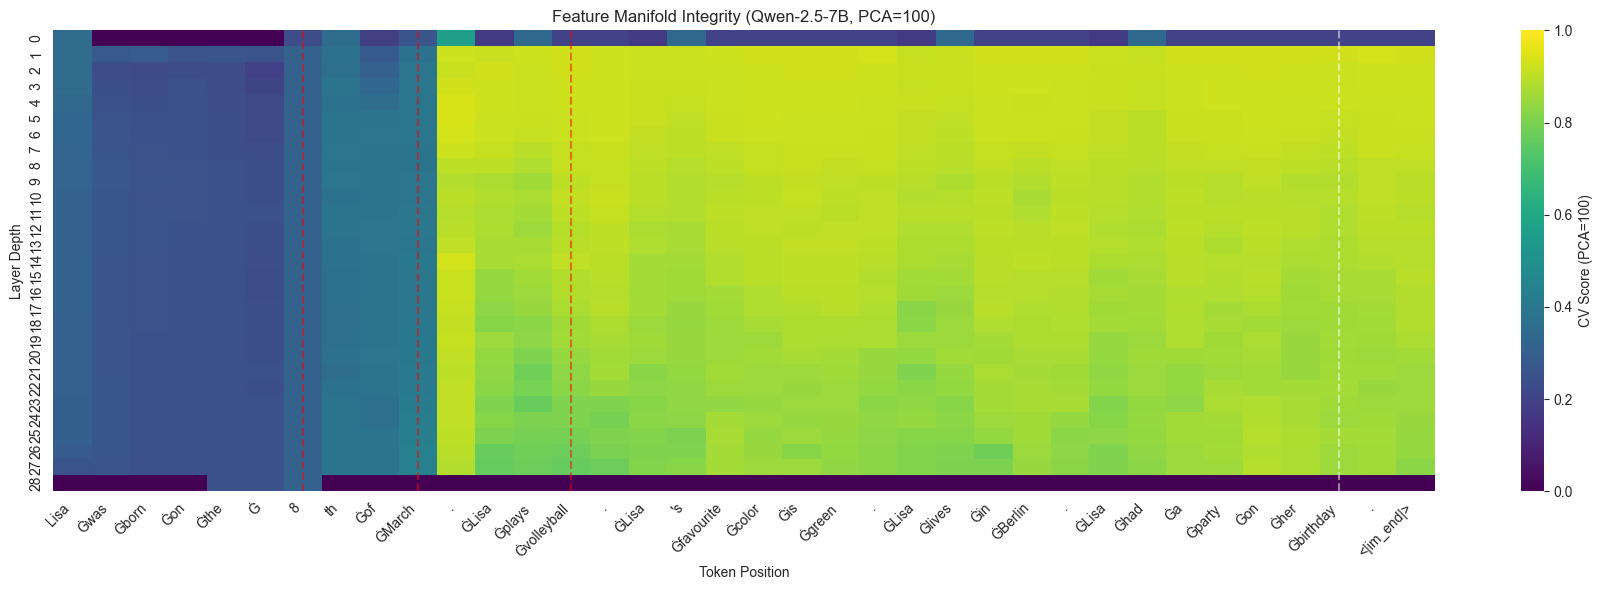


>>> STEP 3: Layer Profiles...


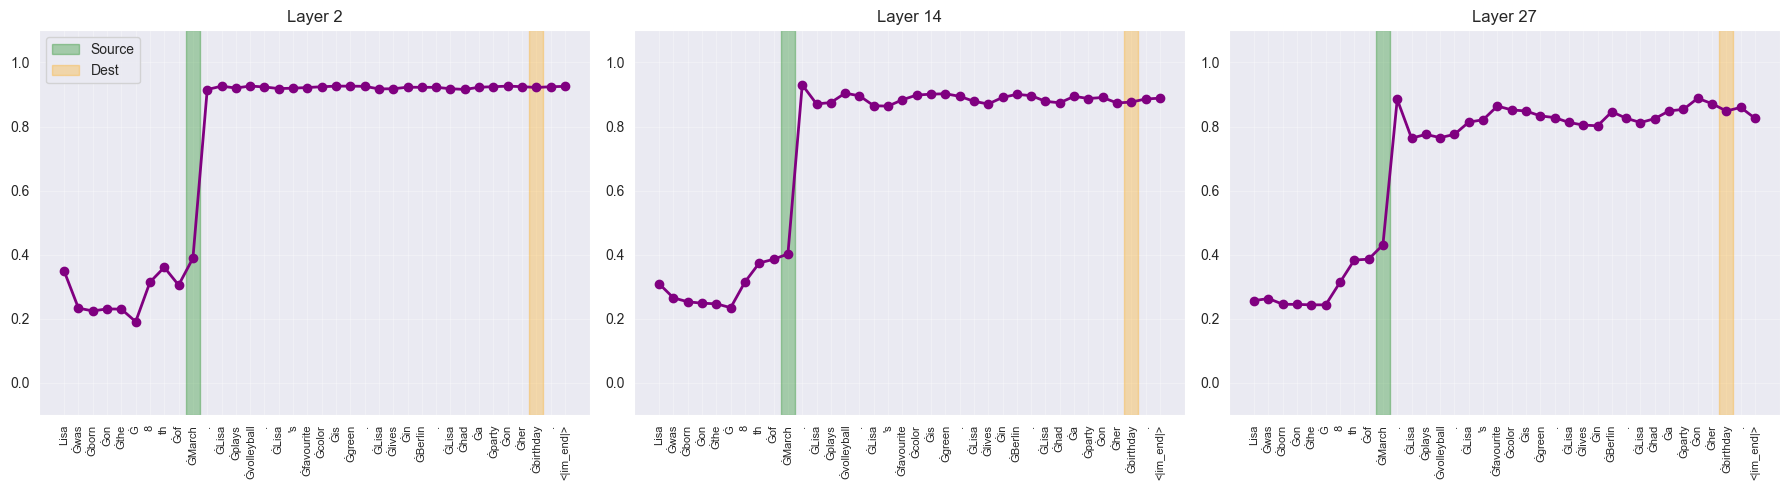


--- EXPERIMENT VERDICT (PCA=100) ---
Max Score at Source     : 0.4307
Max Score at Distractor : 0.9264
Max Score at Birthday   : 0.9285
⚠️ RESULT: Context Smearing.
   The model keeps the date info active everywhere.


In [33]:
# --- MEGA-EVALUATION CELL (PCA=100 + Cross-Validation) ---
# REQUISITES: X_activations and y_labels must be in memory.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from tqdm import tqdm

# --- 1. AUTOMATIC TOKEN MAPPING ---
print(">>> STEP 1: Auto-Detecting Token Indices...")
sample_ids = inputs['input_ids'][0]
tokens_str = [tokenizer.decode([tid]).strip() for tid in sample_ids]
viz_labels = tokenizer.convert_ids_to_tokens(sample_ids)

def find_token_index(keywords):
    if isinstance(keywords, str): keywords = [keywords]
    for key in keywords:
        for i, tok in enumerate(tokens_str):
            if key.lower() in tok.lower() and len(tok) >= 1: return i
    return -1

months_list = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

idx_month = find_token_index(months_list)
idx_bday = find_token_index(["birthday"])
idx_distractor = find_token_index(["volleyball", "lives", "color"])

# Determine Day Index (usually 3 tokens before month, e.g. "13 th of March")
idx_day = idx_month - 3
if idx_day < 0: idx_day = 5 # Fallback

indices = {
    "Source (Day)": idx_day,
    "Source (Month)": idx_month,
    "Destination (Birthday)": idx_bday,
    "Distractor": idx_distractor
}
print(f"Detected Indices: {indices}")

# --- 2. ROBUST ANALYSIS LOOP ---
print("\n>>> STEP 2: Running Analysis (PCA=100 -> CV SMDS)...")

n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
stress_map = np.zeros((n_layers, n_tokens))
shape_hypothesis = CircularShape()

# PCA Settings
PCA_DIMS = 100
pca_reducer = PCA(n_components=PCA_DIMS)

for layer in tqdm(range(n_layers), desc="Analyzing Layers"):
    for token in range(n_tokens):

        # 1. Get Data & Cast (Fixes 4-bit stride issues)
        X_loc = X_activations[:, layer, token, :].astype(np.float32).copy()

        # 2. Normalize (Fixes Layer Norm scaling issues)
        # 4-bit models often produce outliers, StandardScaler tames them.
        scaler = StandardScaler()
        try:
            X_loc = scaler.fit_transform(X_loc)

            # 3. PCA Reduction (Fixes Overfitting)
            # Reduces 3584 -> 100 dims
            X_pca = pca_reducer.fit_transform(X_loc)

            # 4. Cross-Validated SMDS (Measures Generalization)
            # Splits data into 3 chunks. Trains on 2, scores on 1.
            kf = KFold(n_splits=3, shuffle=True, random_state=42)
            fold_scores = []

            for train_idx, test_idx in kf.split(X_pca):
                X_train, X_test = X_pca[train_idx], X_pca[test_idx]
                y_train, y_test = y_labels[train_idx], y_labels[test_idx]

                # Run SMDS
                reducer = SupervisedMDS(manifold=shape_hypothesis, n_components=2)
                reducer.fit(X_train, y_train)
                s = reducer.score(X_test, y_test)

                # Sanity Clip (0.0 to 1.0)
                fold_scores.append(max(0.0, min(1.0, s)))

            # Average the test scores
            stress_map[layer, token] = np.mean(fold_scores)

        except Exception as e:
            stress_map[layer, token] = 0.0

# --- 3. VISUALIZATION ---
plt.figure(figsize=(18, 6))
sns.heatmap(stress_map, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label': 'CV Score (PCA=100)'})
plt.xticks(ticks=np.arange(n_tokens)+0.5, labels=viz_labels, rotation=45, ha='right')
plt.title(f"Feature Manifold Integrity (Qwen-2.5-7B, PCA={PCA_DIMS})")
plt.xlabel("Token Position")
plt.ylabel("Layer Depth")

# Mark key columns
for k, idx in indices.items():
    if idx != -1:
        color = 'white' if 'Destination' in k else 'red'
        plt.axvline(idx+0.5, color=color, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 4. LAYER PROFILES ---
print("\n>>> STEP 3: Layer Profiles...")
layers_to_plot = [2, n_layers // 2, n_layers - 2] # Early, Mid, Late

plt.figure(figsize=(18, 5))
for i, layer in enumerate(layers_to_plot):
    plt.subplot(1, 3, i+1)
    scores = stress_map[layer, :]
    plt.plot(scores, marker='o', color='purple', linewidth=2)

    # Highlight zones
    if idx_month != -1: plt.axvspan(idx_month-0.5, idx_month+0.5, color='green', alpha=0.3, label="Source")
    if idx_bday != -1: plt.axvspan(idx_bday-0.5, idx_bday+0.5, color='orange', alpha=0.3, label="Dest")

    plt.ylim(-0.1, 1.1)
    plt.title(f"Layer {layer}")
    plt.xticks(ticks=range(n_tokens), labels=viz_labels, rotation=90, fontsize=8)
    if i == 0: plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 5. VERDICT ---
score_bday = stress_map[:, idx_bday].max()
score_dist = stress_map[:, idx_distractor].max()
score_source = stress_map[:, idx_month].max()

print("\n--- EXPERIMENT VERDICT (PCA=100) ---")
print(f"Max Score at Source     : {score_source:.4f}")
print(f"Max Score at Distractor : {score_dist:.4f}")
print(f"Max Score at Birthday   : {score_bday:.4f}")

if score_source < 0.2:
    print("❌ FAILURE: Method failed to detect known signal at Source. (PCA might be too aggressive?)")
elif score_bday > score_dist + 0.15:
    print("✅ SUCCESS: 'Just-in-Time' Retrieval Detected!")
    print("   The geometry exists at Source, vanishes, and reappears at Destination.")
elif score_bday > 0.6 and score_dist > 0.6:
    print("⚠️ RESULT: Context Smearing.")
    print("   The model keeps the date info active everywhere.")
else:
    print("❓ RESULT: No clear pattern found.")

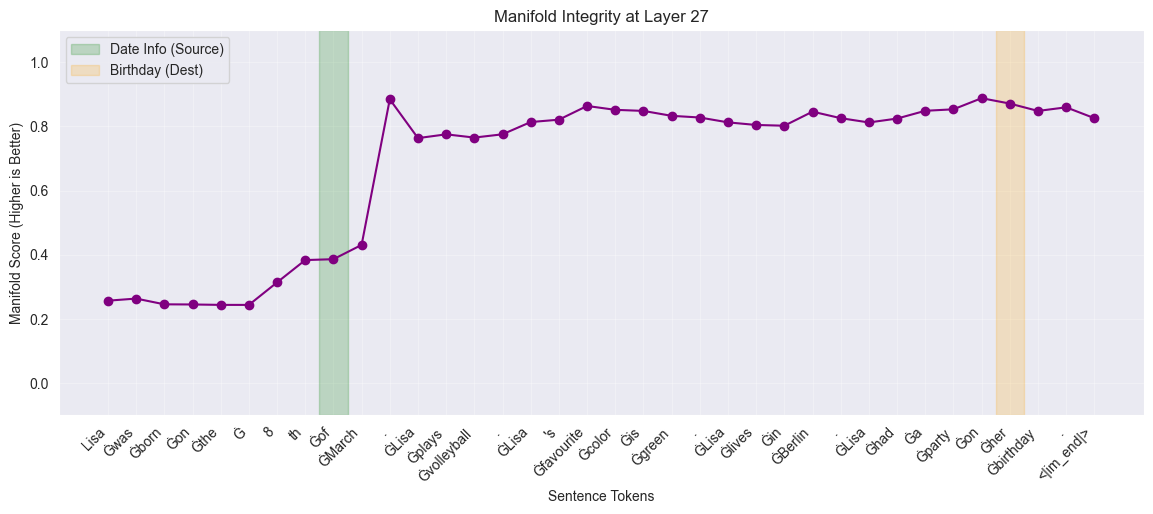

In [39]:
target_layer = 27  # Adjust this based on what the heatmap shows!

plt.figure(figsize=(14, 5))
plt.plot(stress_map[target_layer, :], marker='o', linestyle='-', color='purple')

# Add Labels
plt.xticks(
    ticks=np.arange(len(sample_tokens)),
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.ylabel("Manifold Score (Higher is Better)")
plt.ylim(-0.1, 1.1) # Fix y-axis to see the 0-1 range clearly
plt.xlabel("Sentence Tokens")
plt.title(f"Manifold Integrity at Layer {target_layer}")
plt.grid(True, alpha=0.3)

# Highlight zones
plt.axvspan(7.5, 8.5, color='green', alpha=0.2, label="Date Info (Source)")
plt.axvspan(31.5, 32.5, color='orange', alpha=0.2, label="Birthday (Dest)")
plt.legend()

plt.show()